
# Variational Autoencoder

In this notebook, you will implement a variational autoencoder and its variations. You will learn how to encode images into latent vectors follow gaussian distribution, and how to control images decoded from latent spaces with condtional variational autoencoder.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from visualize_util import visualize_img_batch, one_hot

In [2]:
#Use this if you are running on any Cuda enabled system
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


## Load MNIST Dataset

In [3]:
# TODO
input_dim = 28*28
hidden_dim = 400 
latent_dim = 12
batch_size = 64
n_epochs = 10
# convert data to torch.FloatTensor
transform = transforms.Compose(
        [transforms.ToTensor()]
    ) 

num_classes = 10
portioned_img_size = 14*14

mnist_train = datasets.MNIST('./data', 
               transform=transform, 
               download=True, train=True)

loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          shuffle=True, drop_last=True, num_workers=2)

mnist_test = datasets.MNIST('./data', 
               transform=torchvision.transforms.ToTensor(), 
               download=True, train=False)

loader_test = DataLoader(mnist_test, batch_size=batch_size,
                          shuffle=True, drop_last=True, num_workers=2)                        

In [4]:
class Reshape(nn.Module):
    def __init__(self, *shape, conditional_vec_dim=0, label=None):
        super(Reshape, self).__init__()
        self.shape = shape
        self.conditional_vec_dim = conditional_vec_dim
        

    def forward(self, x):
        # The -1 in reshape method is a placeholder that PyTorch fills in with the appropriate value based on the batch size
        # x = x.view(-1, *self.shape)
        # if self.conditional_vec_dim != 0:
        #     one_hot_vec = F.one_hot(self.conditional_vec_dim, num_classes = self.conditional_vec_dim)
        #     x = torch.cat((x, one_hot_vec), dim = -1)
        return x.view(-1, *self.shape) 

class myVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, conditional_vec_dim=0):
        super(myVAE, self).__init__()
        self.input_dim =  input_dim # H*W
        self.output_dim = input_dim
        self.latent_dim = latent_dim # Z
        self.hidden_dim = hidden_dim 
        self.conditional_vec_dim = conditional_vec_dim # only used in CVAE
        
        # one hot encode the conditional vector
        
        """
        encoder space
        """

        self.encoder = nn.Sequential(
            Reshape(self.input_dim+self.conditional_vec_dim, conditional_vec_dim=self.conditional_vec_dim), # flatten the input (N,1,H,W) -> (N, H*W)
            nn.Linear(self.input_dim+self.conditional_vec_dim, self.hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            ) # input: (N,1,H,W) -> output: (N,hidden_dim)
        """
        bottle neck: mean_layer, logvar_layer 
        """
        self.mean_layer = nn.Linear(self.hidden_dim, self.latent_dim)  # input: (N,hidden_dim) -> output: (N, Z)
        self.logvar_layer = nn.Linear(self.hidden_dim, self.latent_dim)  # input: (N,hidden_dim) -> output: (N, Z)
        
        """
        decoder space
        """
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim+self.conditional_vec_dim, self.hidden_dim),
            nn.LeakyReLU(), 
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_dim, self.output_dim),
            nn.Sigmoid(), # transform the output to (0,1)
            Reshape(1, 28, 28)
            )  # input: (N, Z) -> output: (N,1,H,W)
        
    
    def forward(self, x, label=None, one_hot = False):
        # TODO
        """
        x_hat is the predition output 
        mu is the mean of the distribution fit to the input in the latent space
        logvar is the log of the variance of the distribution fit to the input in the latent space (log for stability)
        """
        # pass
        if self.conditional_vec_dim != 0 and label is not None:
            if one_hot:
                label = F.one_hot(label, num_classes = self.conditional_vec_dim)
            x = torch.cat((x.reshape(x.shape[0], -1), label), dim = -1)
        z = self.encoder(x)
        mu = self.mean_layer(z)
        logvar = self.logvar_layer(z)
        z = self.reparametrize(mu, logvar)
        if self.conditional_vec_dim != 0 and label is not None:
            z = torch.cat((z, label), dim = -1)
        x_hat = self.decoder(z)

        return x_hat, mu, logvar

    @staticmethod
    def reparametrize(mu, logvar):
        # TODO:
        """
        1. Initialize epsilon standard Gaussian distribution with 0 mean and unit variance
        2. epsilon * sigma + mean -> z (where sigma = exp(logvar/2))
        """
        epsilon = torch.randn_like(mu).to(device)
        z = epsilon * torch.exp(logvar * 0.5) + mu
        return z

    def loss_function(x_hat, x, mu, logvar):
        # TODO: Compute negative variational lowerbound loss as described in the handout
        x = x.reshape(-1, input_dim)
        x_hat = x_hat.reshape(-1, input_dim)
        KL_loss = -0.5*torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # KL divergence between the model predicted distribution and the standard normal distribution
        KL_loss /= x.shape[0] # average over batches
        reconstruction_loss = F.binary_cross_entropy(x_hat, x, reduction='sum') # the log likelihood of the input data given the output of all batches 
        reconstruction_loss /= x.shape[0]
        loss =  KL_loss + reconstruction_loss
        return loss

In [5]:
from torchsummary import summary
vae = myVAE(input_dim, hidden_dim, latent_dim).to(device)
summary(vae,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Reshape-1                  [-1, 784]               0
            Linear-2                  [-1, 400]         314,000
         LeakyReLU-3                  [-1, 400]               0
            Linear-4                  [-1, 400]         160,400
         LeakyReLU-5                  [-1, 400]               0
            Linear-6                  [-1, 400]         160,400
            Linear-7                   [-1, 12]           4,812
            Linear-8                   [-1, 12]           4,812
            Linear-9                  [-1, 400]           5,200
        LeakyReLU-10                  [-1, 400]               0
           Linear-11                  [-1, 400]         160,400
        LeakyReLU-12                  [-1, 400]               0
           Linear-13                  [-1, 784]         314,384
          Sigmoid-14                  [

## Train

In [6]:
#TODO
from tqdm import tqdm 
lr = 1e-3
optimizer = torch.optim.Adam(vae.parameters(), lr=lr) 

for epoch in range(n_epochs):
  vae.train()
  train_loss = 0
  loss = None
  with tqdm(loader_train, unit="batch") as tepoch:
    for batch_idx, (data, labels) in enumerate(tepoch):
        #TODO
        # clear the gradients of all optimized variables
        # forward pass:
        # calculate the loss using the loss function defined above
        # backward pass: compute gradient of the loss with respect to model parameters
        # perform a single optimization step (parameter update)
        # update running training loss
        tepoch.set_description("Epoch[{:2d}/{}] train".format(epoch+1, n_epochs))
        optimizer.zero_grad()
        data = data.to(device)
        # data = data.view(-1, input_dim)
        out, mu, logvar = vae(data)
        loss = myVAE.loss_function(out, data, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss/len(loader_train) # compute the running loss 
        tepoch.set_postfix(loss=train_loss.item())
  # print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

Epoch[10/10] train: 100%|██████████| 937/937 [00:08<00:00, 112.05batch/s, loss=107] 


## Results

sampled image


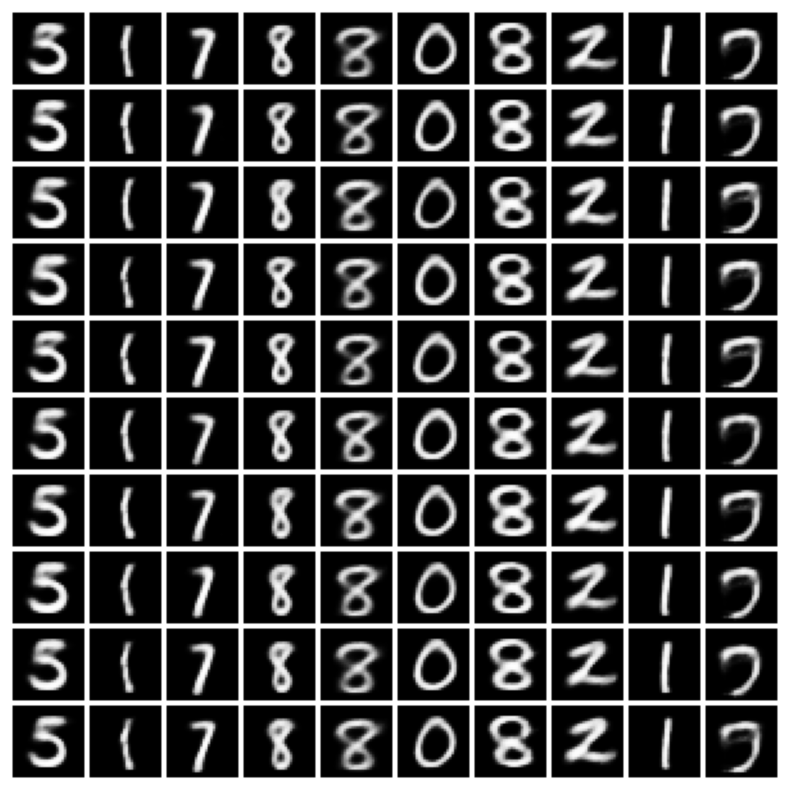

sampled image with larger variance


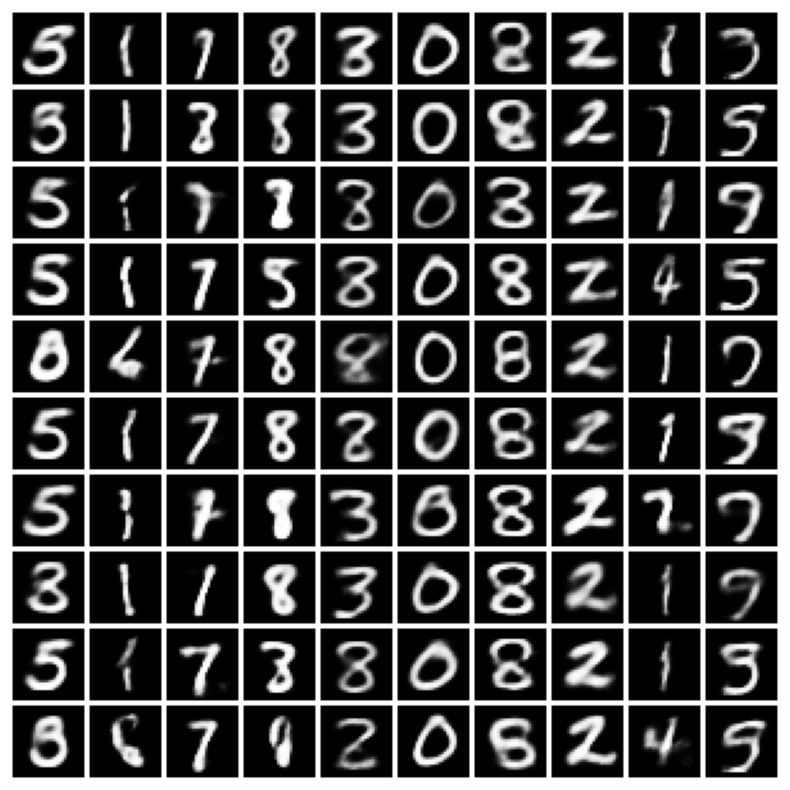

In [7]:
vae.eval()
images = next(iter(loader_test))[0][0:10,:,:,:] # assume batch size >10
images = images.repeat(10,1,1,1)

samples, mu, logvar = vae(images.to(device))
# show vae sampled images
print('sampled image')
visualize_img_batch(samples.detach().cpu().numpy().squeeze())
plt.show()

z = myVAE.reparametrize(mu, logvar+3)
samples = vae.decoder(z)

# show vae sampled images with larger variance
print('sampled image with larger variance')
visualize_img_batch(samples.detach().cpu().numpy().squeeze())
plt.show()

# CVAE

In [8]:
from tqdm import tqdm
cvae = myVAE(input_dim, latent_dim=latent_dim,hidden_dim=hidden_dim, conditional_vec_dim=num_classes).to(device)
lr = 1e-3
optimizer = torch.optim.Adam(cvae.parameters(), lr=lr)

cvae_logs = {'train_loss': []}
for epoch in range(n_epochs):
  cvae.train()
  train_loss = 0
  loss = None
  with tqdm(loader_train, unit="batch") as tepoch:
    for batch_idx, (data, labels) in enumerate(tepoch):
      # Calculate the onehot vector based on the label, use the pre-defined function
      # clear the gradients of all optimized variables
      # Forward pass with the one-hot vector
      # calculate the loss using the loss function defined above
      # backward pass: compute gradient of the loss with respect to model parameters
      # perform a single optimization step (parameter update)
      # update running training loss
      tepoch.set_description("Epoch[{:2d}/{}] train".format(epoch+1, n_epochs))
      optimizer.zero_grad()
      data = data.to(device)
      labels = labels.to(device)
      out, mu, logvar = cvae(data, labels, one_hot = True)
      loss = myVAE.loss_function(out, data, mu, logvar)
      loss.backward()
      optimizer.step()
      train_loss += loss/len(loader_train)
      tepoch.set_postfix(loss=train_loss.item())
        
  cvae_logs['train_loss'].append(train_loss.item())
    # print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

  0%|          | 0/937 [00:00<?, ?batch/s]

Epoch[10/10] train: 100%|██████████| 937/937 [00:08<00:00, 105.64batch/s, loss=101] 


## Results

sampled image


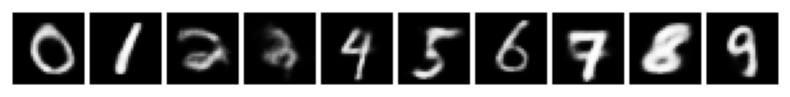

In [9]:
z = torch.randn(10, latent_dim)
c = torch.eye(10, 10) # [one hot labels for 0-9]
z = torch.cat((z,c), dim=-1).to(device)
cvae.eval()
samples = cvae.decoder(z)
# show vae sampled images with larger variation
print('sampled image')
visualize_img_batch(samples.detach().cpu().numpy().squeeze())
plt.show()

## CVAE + structured output prediction

In [10]:
cvae = myVAE(input_dim, latent_dim=latent_dim, hidden_dim=hidden_dim, conditional_vec_dim = portioned_img_size)
cvae.to(device)
lr = 1e-3
optimizer = torch.optim.Adam(cvae.parameters(), lr=lr)
cvae_struc_logs = {'train_loss': []}
for epoch in range(n_epochs):
  cvae.train()
  train_loss = 0
  loss = None
  with tqdm(loader_train, unit="batch") as tepoch:
    for batch_idx, (data, labels) in enumerate(tepoch):
        # Slice the bottom left portion of the image
        # Flatten it/ reshape it to (-1,14*14)
        # clear the gradients of all optimized variables
        # Forward pass with the conditional vector
        # calculate the loss using the loss function defined above
        # backward pass: compute gradient of the loss with respect to model parameters
        # perform a single optimization step (parameter update)
        # update running training loss
        tepoch.set_description("Epoch[{:2d}/{}] train".format(epoch+1, n_epochs))
        optimizer.zero_grad()
        # slice the bottom left protion of the image
        slice = data[:,:, 14:, :14].to(device)
        slice = slice.view(-1, portioned_img_size)
        data = data.to(device)
        out, mu, logvar = cvae(data, slice)
        loss = myVAE.loss_function(out, data, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()/len(loader_train)
        tepoch.set_postfix(loss=train_loss)
  cvae_struc_logs['train_loss'].append(train_loss)
  # print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

  0%|          | 0/937 [00:00<?, ?batch/s]

Epoch[10/10] train: 100%|██████████| 937/937 [00:08<00:00, 105.24batch/s, loss=86.8]


## Baseline NN for structured output prediction

In [11]:
class BaselineNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        #TODO
        self.input_dim  = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        # three layer network (same as myVAE)
        self.decoder = nn.Sequential(
            Reshape(self.input_dim), # flatten the input (N,1,H,W) -> (N, H*W
            nn.Linear(self.input_dim, self.hidden_dim),
            nn.LeakyReLU(), 
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_dim, self.output_dim),
            nn.Sigmoid(), # transform the output to (0,1)
            Reshape(1, 28, 28)
            )  # input: (N, Z) -> output: (N,1,H,W)
        
    
    def forward(self, z):
        #TODO
        z = self.decoder(z)
        return z

In [12]:
baseline =  BaselineNN(input_dim = portioned_img_size, hidden_dim=hidden_dim, output_dim=28*28).to(device)
criterion = nn.MSELoss() #TODO
lr = 1e-3
optimizer = torch.optim.Adam(baseline.parameters(), lr = lr) #TODO
baseline_logs = {'train_loss': []}

for epoch in range(0, n_epochs):
  baseline.train()
  train_loss = 0
  loss = None
  with tqdm(loader_train, unit="batch") as tepoch:
    for batch_idx, (data, labels) in enumerate(tepoch):
        # Slice the bottom left portion of the image
        # Flatten it/ reshape it to (-1,14*14)
        # clear the gradients of all optimized variables
        # Forward pass with the conditional vector as input
        # calculate the loss using the criterion function defined above
        # backward pass: compute gradient of the loss with respect to model parameters
        # perform a single optimization step (parameter update)
        # update running training loss
        tepoch.set_description("Epoch[{:2d}/{}] train".format(epoch+1, n_epochs))
        optimizer.zero_grad()
        data = data.to(device)
        slice = data[:,:, 14:, :14].to(device)
        out = baseline(slice.reshape(-1, portioned_img_size))
        loss = criterion(out, data)  # fix me !!!!
        loss.backward()
        optimizer.step()
        train_loss += loss.item()/len(loader_train)
        tepoch.set_postfix(loss=train_loss)
  baseline_logs['train_loss'].append(train_loss)
  # print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

  0%|          | 0/937 [00:00<?, ?batch/s]

Epoch[10/10] train: 100%|██████████| 937/937 [00:06<00:00, 141.76batch/s, loss=0.0257] 


## Results

Ground truth


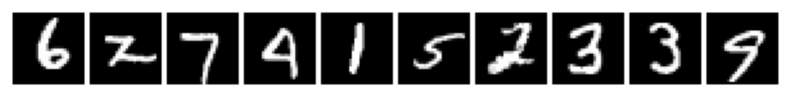

Quarter image


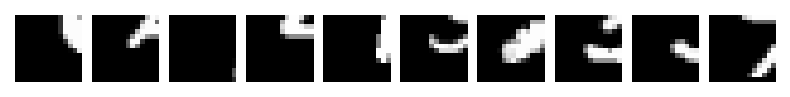

Baseline results


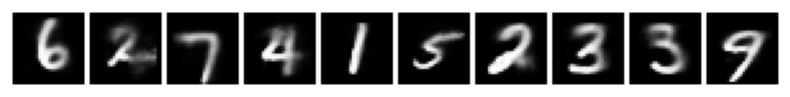

CVAE results


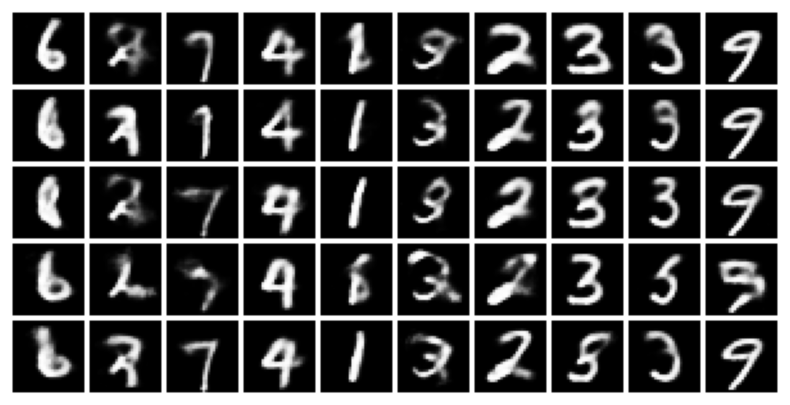

In [14]:
full_imgs = next(iter(loader_test))[0][0:10,:,:,:]
# TODO
# Slice the bottom left portion of the image
quad_imgs = full_imgs[:,:,14:, :14] #(10,1,14,14)

print('Ground truth')
visualize_img_batch(full_imgs.detach().cpu().numpy().squeeze())
plt.show()

print('Quarter image')
visualize_img_batch(quad_imgs.detach().cpu().numpy().squeeze())
plt.show()

print('Baseline results')
baseline.eval()
samples = baseline(quad_imgs.to(device))
visualize_img_batch(samples.detach().cpu().numpy().squeeze())
plt.show()

print('CVAE results')
# cvae = cvae.cpu() # (add by me) move the model to cpu
cvae.eval()
num_random = 5
quad_imgs = quad_imgs.repeat(num_random ,1,1,1)
quad_imgs = torch.reshape(quad_imgs,(-1, 14*14)).to(device)

z = torch.randn(num_random*10, latent_dim).to(device)
z = torch.cat((z, quad_imgs), dim=-1) #TODO: concat latent vector with the conditional_vec (quad_imgs)
samples = cvae.decoder(z).data
visualize_img_batch(samples.detach().cpu().numpy().squeeze())
plt.show()

In [15]:
# store logs 
import json 
all_logs = {'cvae': cvae_logs, 'cvae_struc': cvae_struc_logs, 'baseline': baseline_logs}
for item in all_logs.keys():
    with open('./logs/' + item + '_logs.json', 'w') as f:
        json.dump(all_logs[item], f)